<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_antana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=8033fc0b76a8655207e784069dc637ec3eea6d92325a5a1b3c9b1f589b0e16fa
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [24]:
# Voa vaovao (observed incidence)
Ivaotana = tilyvoatana['Voatomb']

dIvao = pd.DataFrame(data =Ivaotana)

daty_data_manom = datetime.date(2020,5,6)
daty_data_mifar = datetime.date(2020,6,18)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


# Fikajiana ny APE (Computing the APE)

In [7]:
# 6/ Computation of the Accumulated Predictive Error (APE)

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))


print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

For k = 9, APE91 = 4916.0479022974205
APEt91 = [(293.84164495964217, datetime.date(2020, 6, 17)), (205.36658170202554, datetime.date(2020, 6, 16)), (215.87464693412494, datetime.date(2020, 6, 15)), (282.31249615986394, datetime.date(2020, 6, 14)), (274.4681418435716, datetime.date(2020, 6, 13)), (235.77878550486244, datetime.date(2020, 6, 12)), (226.01498493824616, datetime.date(2020, 6, 11)), (210.1746962960439, datetime.date(2020, 6, 10)), (219.91011836634996, datetime.date(2020, 6, 9)), (241.42215332280793, datetime.date(2020, 6, 8)), (171.59723068542613, datetime.date(2020, 6, 7)), (179.32315699020356, datetime.date(2020, 6, 6)), (126.31313388686216, datetime.date(2020, 6, 5)), (168.72678823128257, datetime.date(2020, 6, 4)), (179.0025791802597, datetime.date(2020, 6, 3)), (107.74836240084073, datetime.date(2020, 6, 2)), (156.6528906160197, datetime.date(2020, 6, 1)), (140.84003851161307, datetime.date(2020, 5, 31)), (127.95365305764692, datetime.date(2020, 5, 30)), (68.09640287084

In [8]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [516.5194369760796, 976.6765790031632, 1541.7312050926248, 2181.2185346895203, 2852.7237873790014, 3535.7979389028487, 4214.085108001832]
APEk2 = [4.638111878570162, 13.64216989934469, 21.841084603804433, 26.83326039126735, 41.522298666962314, 53.87320846013845, 70.22852822082574]


In [9]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = 4986.276430518246
APEk = [521.1575488546498, 990.3187489025079, 1563.5722896964292, 2208.0517950807875, 2894.2460860459637, 3589.671147362987, 4284.313636222658]
APE = [521.1575488546498, 990.3187489025079, 1563.5722896964292, 2208.0517950807875, 2894.2460860459637, 3589.671147362987, 4284.313636222658, 4986.276430518246]
2


# Fifidianana ireo taha mialoha (prior parameters)

In [10]:
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


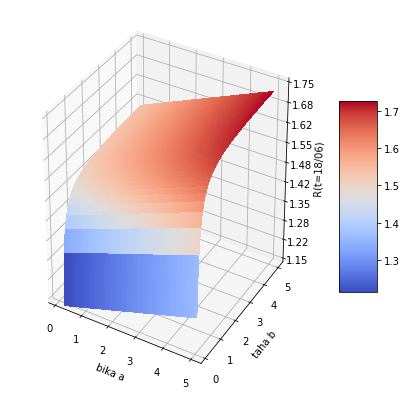

In [13]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.15, 1.75)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=18/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt35186_anta.eps')

plt.show()

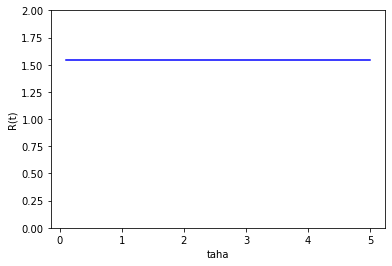

taha* = 1
R(t= 2020-06-18 ) = 1.5462893930455026 = bika*


In [14]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Fanombanana ny R(t) (estimation of R(t))

In [15]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-06-18 : 0.0
Salan'isa R hoan'ny 2020-06-08 : 2.4845403238629427
Kartily @ 75% R hoan'ny 2020-06-08 : 2.706467229601204
Kartily @ 25% R hoan'ny 2020-06-08 : 2.245439108300925
Salan'isa R hoan'ny 2020-06-18 : 1.5462893931068034
Kartily @ 75% R hoan'ny 2020-06-18 : 1.7006400216113062
Kartily @ 25% R hoan'ny 2020-06-18 : 1.3784416603923468


In [16]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


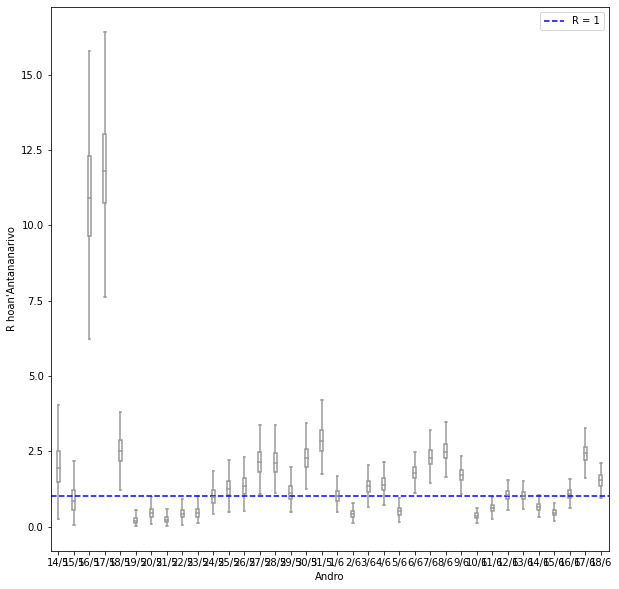

In [17]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'Antananarivo")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt35186_anta.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


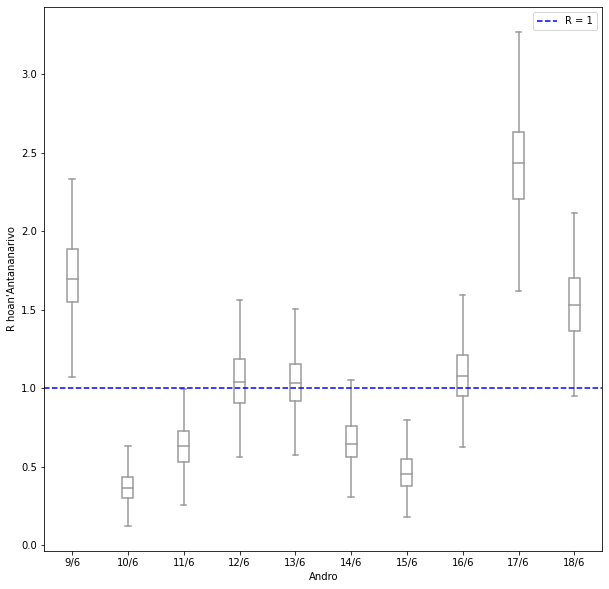

In [18]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'Antananarivo")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt3518610_anta.eps')
plt.show()

# Ny 7 andro manaraka

In [19]:
# Choice of R(t) for the forecasting

# Dates for which R(t) is minimum and maximum during the last 10 days

daty_amba = datetime.date(2020,6,10)
daty_ambo = datetime.date(2020,6,17)

In [25]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_vina = daty_ambo

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_vina)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_vina)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [26]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_hoav.append(data_amboar)

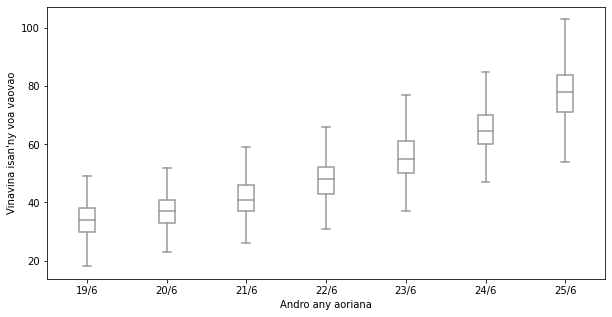

In [27]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst, data_hoav, color='white', width=0.2, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Ivbo186hoav_anta.eps')

plt.show()

In [28]:
daty_oh = datetime.date(2020,6,20)

print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao.loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina R hoan'ny 2020-06-20 : 2.393255171989327
Vinavina kartily @ 75% R hoan'ny 2020-06-20 : 2.5752942846600897
Vinavina kartily @ 25% R hoan'ny 2020-06-20 : 2.199380305862515
Vinavina isan'ny voa vaovao hoan'ny 2020-06-20 : Voatomb    37.0
Name: 2020-06-20 00:00:00, dtype: float64
Vinavina kartily @ 75% R hoan'ny 2020-06-20 : [47.]
Vinavina kartily @ 25% R hoan'ny 2020-06-20 : [33.]
